In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
import glob
import os
from torchvision import models
import time 
import random
import matplotlib.pyplot as plt

In [2]:
# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Répertoires d'entraînement et de test
train_dir = 'C:/Users/ouedraogo080976/Desktop/OpenClassroom/PROJET 7/Développez_une_preuve_de_concept_OUEDRAOGO_Mahamady/data/train'
test_dir = 'C:/Users/ouedraogo080976/Desktop/OpenClassroom/PROJET 7/Développez_une_preuve_de_concept_OUEDRAOGO_Mahamady/data/test'

In [4]:
class cifar(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('\\')[-1].split('.')[0].split('_')[0]        

        if label == 'airplane':
            label = 0
        elif label == 'automobile':
            label = 1
        elif label == 'bird':
            label = 2
        elif label == 'cat':
            label = 3
        elif label == 'deer':
            label = 4
        elif label == 'dog':
            label = 5
        elif label == 'frog':
            label = 6
        elif label == 'horse':
            label = 7
        elif label == 'ship':
            label = 8
        elif label == 'truck':
            label = 9

        return img_transformed, label

Nombre d'images dans le répertoire d'entraînement: 1182
Nombre d'images dans le répertoire de test: 300


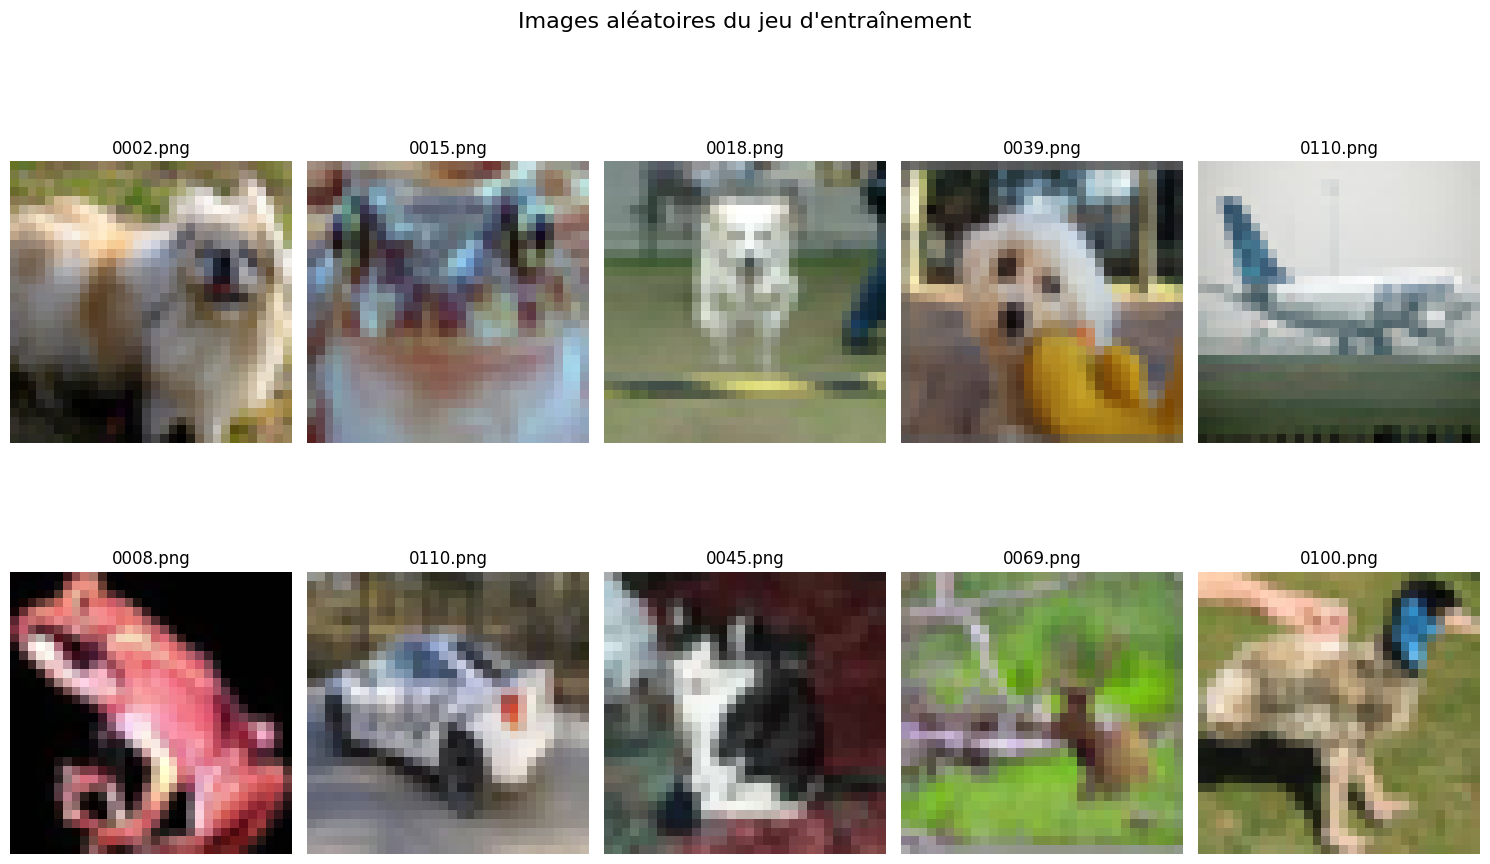

In [5]:
# Fonction pour récupérer une liste de tous les chemins d'images
def get_image_paths(directory):
    return [os.path.join(root, file)
            for root, dirs, files in os.walk(directory)
            for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Récupérer les chemins des images
train_images = get_image_paths(train_dir)
test_images = get_image_paths(test_dir)

# Afficher le nombre total d'images trouvées
print(f"Nombre d'images dans le répertoire d'entraînement: {len(train_images)}")
print(f"Nombre d'images dans le répertoire de test: {len(test_images)}")

# Sélectionner 10 images aléatoires dans les données d'entraînement
random_train_images = random.sample(train_images, min(len(train_images), 10))

# Fonction pour afficher les images
def display_images(image_paths, title):
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(image_paths):
        plt.subplot(2, 5, i + 1)  # Crée une grille 2x5
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')  # Désactive les axes
        plt.title(f"{os.path.basename(img_path)}")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Affichage des images aléatoires
display_images(random_train_images, "Images aléatoires du jeu d'entraînement")

### Le code d'entraînement pour ResNet50 avec le calcul de la perte et de la précision pour chaque époque.

In [7]:
# Transformations pour les images (redimensionnement, conversion en tensor, normalisation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionner les images à 224x224
    transforms.ToTensor(),  # Convertir les images en tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalisation selon ImageNet
])

# Chargement des datasets (train et validation)
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# DataLoader pour charger les données
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Paramètres d'entraînement
num_classes = len(train_dataset.classes)  # Nombre de classes basé sur les sous-dossiers de 'train_dir'
learning_rate = 0.001
num_epochs = 10


# Charger le modèle ResNet50 pré-entraîné
model = models.resnet50(pretrained=True)


# Geler les couches de convolution pour ne pas les entraîner
for param in model.parameters():
    param.requires_grad = False

# Remplacer la couche fully connected pour s'adapter à notre nombre de classes
model.fc = nn.Linear(model.fc.in_features, num_classes, bias=True)

# Déplacer le modèle sur le périphérique sélectionné (CPU ou GPU)
model = model.to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

# Entraînement du modèle
for epoch in range(num_epochs):
    start_time = time.time()  # Début du chronométrage pour l'époque
    model.train()  # Passer le modèle en mode entraînement
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Boucle d'entraînement sur les batches
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Déplacer vers le GPU ou CPU

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Avant, arrière et optimisation
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Suivi des statistiques
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calcul de la précision de l'entraînement
    train_accuracy = 100 * correct / total
    epoch_time = time.time() - start_time  # Temps pour l'époque

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Time: {epoch_time:.2f} seconds")

    # Validation après chaque époque
    start_val_time = time.time()  # Début du chronométrage pour la validation
    model.eval()  # Passer le modèle en mode évaluation
    val_loss = 0.0
    correct = 0
    total = 0
    
    # Boucle de validation
    with torch.no_grad():  # Pas de calcul des gradients pendant la validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calcul de la précision de la validation
    val_accuracy = 100 * correct / total
    val_time = time.time() - start_val_time  # Temps pour la validation

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation Time: {val_time:.2f} seconds")

# Sauvegarder le modèle après l'entraînement
torch.save(model.state_dict(), "ResNet50_transfer_learning.pth")

C:\Users\ouedraogo080976\AppData\Local\anaconda\envs\tf_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ouedraogo080976\AppData\Local\anaconda\envs\tf_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\ouedraogo080976/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [01:00<00:00, 1.69MB/s]


Epoch 1/10, Loss: 68.8558, Accuracy: 36.72%, Time: 5.42 seconds
Validation Loss: 14.3276, Validation Accuracy: 50.67%, Validation Time: 1.25 seconds
Epoch 2/10, Loss: 45.5595, Accuracy: 60.49%, Time: 4.69 seconds
Validation Loss: 11.5008, Validation Accuracy: 61.00%, Validation Time: 1.19 seconds
Epoch 3/10, Loss: 33.8201, Accuracy: 74.87%, Time: 4.74 seconds
Validation Loss: 10.3124, Validation Accuracy: 62.00%, Validation Time: 1.18 seconds
Epoch 4/10, Loss: 30.5122, Accuracy: 74.96%, Time: 4.73 seconds
Validation Loss: 9.4417, Validation Accuracy: 67.67%, Validation Time: 1.19 seconds
Epoch 5/10, Loss: 26.7972, Accuracy: 78.34%, Time: 4.69 seconds
Validation Loss: 9.1345, Validation Accuracy: 65.67%, Validation Time: 1.16 seconds
Epoch 6/10, Loss: 23.7090, Accuracy: 80.80%, Time: 4.94 seconds
Validation Loss: 8.9282, Validation Accuracy: 69.67%, Validation Time: 1.25 seconds
Epoch 7/10, Loss: 23.5298, Accuracy: 80.37%, Time: 5.15 seconds
Validation Loss: 8.6964, Validation Accuracy:

### Le code d'entraînement pour ConvNeXt avec le calcul de la perte et de la précision pour chaque époque.

In [18]:
# Appliquer des transformations aux images (redimensionnement, conversion en tensor, normalisation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionner les images à 224x224
    transforms.ToTensor(),  # Convertir les images en tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalisation selon ImageNet
])

# Charger les datasets (train et validation)
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# Charger les données avec DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Paramètres
num_classes = len(train_dataset.classes)  # Nombre de classes basé sur les sous-dossiers de 'train_dir'
learning_rate = 0.001
num_epochs = 10

# Charger le modèle ConvNeXt pré-entraîné
model = models.convnext_base(weights="DEFAULT")  # Utilisation du modèle ConvNeXt pré-entraîné

# Geler les couches de convolution
for param in model.parameters():
    param.requires_grad = False

# Remplacer le classificateur par un nouveau pour la tâche personnalisée
model.classifier[2] = nn.Linear(in_features=model.classifier[2].in_features, out_features=num_classes, bias=True)

# Déplacer le modèle vers l'appareil sélectionné (CPU ou GPU)
model = model.to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[2].parameters(), lr=learning_rate)

# Entraînement du modèle
for epoch in range(num_epochs):
    start_time = time.time()  # Début du chronométrage pour l'époque
    model.train()  # Passer le modèle en mode entraînement
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Déplacer vers le GPU ou CPU

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Avant, arrière et optimisation
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Suivi des statistiques
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    epoch_time = time.time() - start_time  # Temps de calcul pour l'époque

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Time: {epoch_time:.2f} seconds")

    # Validation
    start_val_time = time.time()  # Début du chronométrage pour la validation
    model.eval()  # Passer le modèle en mode évaluation
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # Pas de calcul des gradients pendant la validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_time = time.time() - start_val_time  # Temps de calcul pour la validation

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation Time: {val_time:.2f} seconds")

# Sauvegarder le modèle après l'entraînement
torch.save(model.state_dict(), "ConvNeXt_transfer_learning.pth")

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to C:\Users\ouedraogo080976/.cache\torch\hub\checkpoints\convnext_base-6075fbad.pth
100%|███████████████████████████████████████████████████████████████████████████████| 338M/338M [01:36<00:00, 3.69MB/s]


Epoch 1/10, Loss: 55.0132, Accuracy: 68.10%, Time: 12.37 seconds
Validation Loss: 8.2820, Validation Accuracy: 89.00%, Validation Time: 3.06 seconds
Epoch 2/10, Loss: 24.2453, Accuracy: 88.92%, Time: 12.14 seconds
Validation Loss: 4.8417, Validation Accuracy: 90.67%, Validation Time: 3.07 seconds
Epoch 3/10, Loss: 16.0514, Accuracy: 92.39%, Time: 12.05 seconds
Validation Loss: 3.7084, Validation Accuracy: 91.33%, Validation Time: 2.92 seconds
Epoch 4/10, Loss: 12.7710, Accuracy: 93.15%, Time: 12.30 seconds
Validation Loss: 3.2279, Validation Accuracy: 92.33%, Validation Time: 3.12 seconds
Epoch 5/10, Loss: 10.7400, Accuracy: 93.82%, Time: 12.49 seconds
Validation Loss: 2.8745, Validation Accuracy: 91.67%, Validation Time: 3.12 seconds
Epoch 6/10, Loss: 9.4643, Accuracy: 94.67%, Time: 12.54 seconds
Validation Loss: 2.6534, Validation Accuracy: 92.67%, Validation Time: 3.13 seconds
Epoch 7/10, Loss: 8.5101, Accuracy: 95.18%, Time: 12.51 seconds
Validation Loss: 2.4803, Validation Accurac

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\ouedraogo080976/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [01:12<00:00, 1.42MB/s]


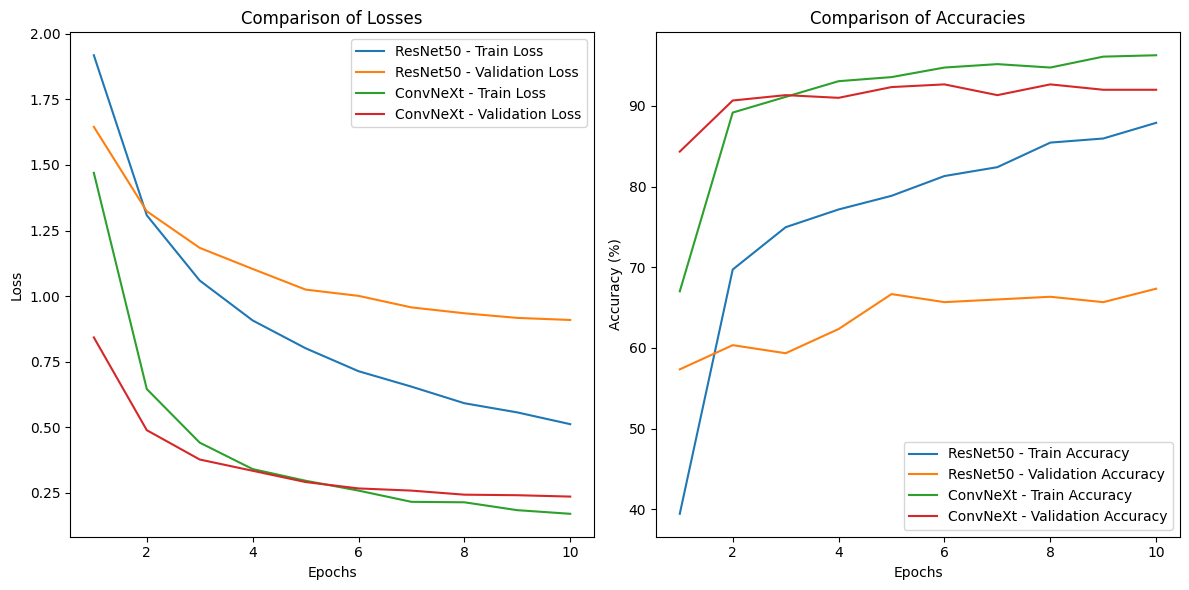

In [10]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 0.001

# Appliquer des transformations aux images (redimensionnement, conversion en tensor, normalisation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionner les images à 224x224
    transforms.ToTensor(),  # Convertir les images en tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalisation selon ImageNet
])

# Charger les datasets (train et validation)
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Charger les données avec DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Paramètres
num_classes = len(train_dataset.classes)

# *** Entraînement du modèle ResNet50 ***
# Charger le modèle ResNet50 pré-entraîné
resnet_model = models.resnet50(weights="DEFAULT")

# Geler les couches de convolution
for param in resnet_model.parameters():
    param.requires_grad = False

# Remplacer le classificateur par un nouveau pour la tâche personnalisée
resnet_model.fc = nn.Linear(in_features=resnet_model.fc.in_features, out_features=num_classes, bias=True)

# Déplacer le modèle vers l'appareil sélectionné (CPU ou GPU)
resnet_model = resnet_model.to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet_model.fc.parameters(), lr=learning_rate)

# Variables pour suivre les résultats
resnet_train_losses, resnet_val_losses = [], []
resnet_train_accuracies, resnet_val_accuracies = [], []

# Entraînement du modèle ResNet50
for epoch in range(num_epochs):
    # Entraînement
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_resnet.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    resnet_train_losses.append(running_loss / len(train_loader))
    resnet_train_accuracies.append(train_accuracy)

    # Validation
    resnet_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    resnet_val_losses.append(val_loss / len(val_loader))
    resnet_val_accuracies.append(val_accuracy)

# *** Entraînement du modèle ConvNeXt ***
# Charger le modèle ConvNeXt pré-entraîné
convnext_model = models.convnext_base(weights="DEFAULT")

# Geler les couches de convolution
for param in convnext_model.parameters():
    param.requires_grad = False

# Remplacer le classificateur par un nouveau pour la tâche personnalisée
convnext_model.classifier[2] = nn.Linear(in_features=convnext_model.classifier[2].in_features, out_features=num_classes, bias=True)

# Déplacer le modèle vers l'appareil sélectionné (CPU ou GPU)
convnext_model = convnext_model.to(device)

# Définir l'optimiseur pour ConvNeXt
optimizer_convnext = optim.Adam(convnext_model.classifier[2].parameters(), lr=learning_rate)

# Variables pour suivre les résultats
convnext_train_losses, convnext_val_losses = [], []
convnext_train_accuracies, convnext_val_accuracies = [], []

# Entraînement du modèle ConvNeXt
for epoch in range(num_epochs):
    # Entraînement
    convnext_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_convnext.zero_grad()
        outputs = convnext_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_convnext.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    convnext_train_losses.append(running_loss / len(train_loader))
    convnext_train_accuracies.append(train_accuracy)

    # Validation
    convnext_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = convnext_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    convnext_val_losses.append(val_loss / len(val_loader))
    convnext_val_accuracies.append(val_accuracy)

# Comparaison des modèles
epochs = range(1, num_epochs + 1)

# Graphiques de la perte
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, resnet_train_losses, label='ResNet50 - Train Loss')
plt.plot(epochs, resnet_val_losses, label='ResNet50 - Validation Loss')
plt.plot(epochs, convnext_train_losses, label='ConvNeXt - Train Loss')
plt.plot(epochs, convnext_val_losses, label='ConvNeXt - Validation Loss')
plt.title('Comparison of Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Graphiques de la précision
plt.subplot(1, 2, 2)
plt.plot(epochs, resnet_train_accuracies, label='ResNet50 - Train Accuracy')
plt.plot(epochs, resnet_val_accuracies, label='ResNet50 - Validation Accuracy')
plt.plot(epochs, convnext_train_accuracies, label='ConvNeXt - Train Accuracy')
plt.plot(epochs, convnext_val_accuracies, label='ConvNeXt - Validation Accuracy')
plt.title('Comparison of Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()

# Sauvegarder les modèles
torch.save(resnet_model.state_dict(), "ResNet50_transfer_learning.pth")
torch.save(convnext_model.state_dict(), "ConvNeXt_transfer_learning.pth")